Encontrar el logotipo de la gaseosa dentro de las imagenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

1. (4 puntos) Obtener una deteccion del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validad un algoritmo para multiples detecciones en la imagen coca_multi.png con el mismo template del item 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imagenes

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la deteccion.

In [191]:
import numpy as np
import pandas as pd
import cv2 as cv
import seaborn as sns
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

In [192]:
# Cargamos las imagenes
img_path1 = "../Material_TPs/TP3/images"
img_path2 = "../Material_TPs/TP3/template"
img1 = cv.imread(img_path1 + '/coca_logo_1.png')
img2 = cv.imread(img_path1 + '/coca_logo_2.png')
img3 = cv.imread(img_path1 + '/coca_multi.png')
img4 = cv.imread(img_path1 + '/coca_retro_1.png')
img5 = cv.imread(img_path1 + '/coca_retro_2.png')
img6 = cv.imread(img_path1 + '/COCA-COLA-LOGO.jpg')
img7 = cv.imread(img_path1 + '/logo_1.png')
template = cv.imread(img_path2 + '/pattern.png')

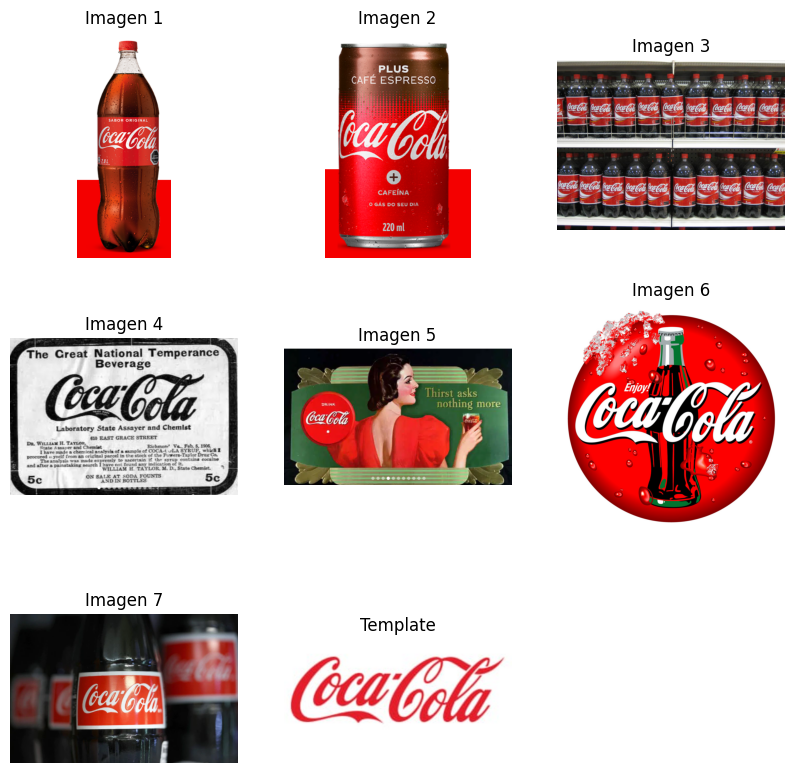

In [193]:
# Ver las imagenes
plt.figure(figsize=(10,10))
plt.subplot(3, 3, 1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 1')
plt.axis('off')
plt.subplot(3, 3, 2)
plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 2')
plt.axis('off')
plt.subplot(3, 3, 3)
plt.imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 3')
plt.axis('off')
plt.subplot(3, 3, 4)
plt.imshow(cv.cvtColor(img4, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 4')
plt.axis('off')
plt.subplot(3, 3, 5)
plt.imshow(cv.cvtColor(img5, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 5')
plt.axis('off')
plt.subplot(3, 3, 6)
plt.imshow(cv.cvtColor(img6, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 6')
plt.axis('off')
plt.subplot(3, 3, 7)
plt.imshow(cv.cvtColor(img7, cv.COLOR_BGR2RGB))
plt.title(f'Imagen 7')
plt.axis('off')
plt.subplot(3, 3, 8)
plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
plt.title(f'Template')
plt.axis('off')
plt.show()

In [194]:
# Trabajaremos las imagenes en escala de grises

img1_gris = cv.imread(img_path1 + '/coca_logo_1.png', cv.IMREAD_GRAYSCALE)
img2_gris = cv.imread(img_path1 + '/coca_logo_2.png', cv.IMREAD_GRAYSCALE)
img3_gris = cv.imread(img_path1 + '/coca_multi.png', cv.IMREAD_GRAYSCALE)
img4_gris = cv.imread(img_path1 + '/coca_retro_1.png', cv.IMREAD_GRAYSCALE)
img5_gris = cv.imread(img_path1 + '/coca_retro_2.png', cv.IMREAD_GRAYSCALE)
img6_gris = cv.imread(img_path1 + '/COCA-COLA-LOGO.jpg', cv.IMREAD_GRAYSCALE)
img7_gris = cv.imread(img_path1 + '/logo_1.png', cv.IMREAD_GRAYSCALE)
template_gris = cv.imread(img_path2 + '/pattern.png', cv.IMREAD_GRAYSCALE)

# Quitamos los pedazos blancos del template para evitar match en zonas donde no deberia.
#template_gris = template_gris[27:152,7:388]

En las imagenes dadas, el logo de coca cola es de color distinto al del template, algunas imagenes tienen combras, otras tienen reflejos, en otras estan distorsionadas por la forma cilindrica del producto, etc.

Los metodos normales template matching no funcionan para este caso, ya que los mismos son sensibles a cambios de rotacion, escala, el angulo en el que son vistos, o reflejos. 

Probamos agregar algunos pasos para mejorar el mecanismo de tempalte matching:
1. Filtro gaussiano (mejora la deteccion de bordes)
2. Deteccion de bordes (probamos Sobel, Canny y piramides LoG)
3. Ciclar y escalar de template para corregir la proporcion de tamaño entre las imagenes y el template
4. Como ultima estrategia, se podria modificar el template quitandole una parte a la izquierda y otra a la derecha, de modo que en vez de probar "Coca Cola", probamos "ca Co". En la mayoria de las imagenes, Coca Cola está sobre un cilindro, por lo tanto la parte inicial y la parte final de Coca Cola (osea Co y la) están distorsionadas. Remover esto nos permitiria eliminar los errores por distorsion de perspectiva.


In [195]:
def edge_detection(image, 
                     blur = True, 
                     k_size_blur = (3,3),
                     sigma = 1,
                     edge_type = 'Canny', 
                     thres1 = 0, 
                     thres2 = 255, 
                     k_size_sobel = 5,
                     pyr_steps = 5
                    ):
    if blur:
        image = cv.GaussianBlur(image, k_size_blur, sigmaX=sigma, sigmaY=sigma)
    match edge_type:
        case 'Canny':
            edges = cv.Canny(image, thres1, thres2,L2gradient=True)
            return edges
        case 'SobelX':
            sobelx = cv.Sobel(image, ddepth = cv.CV_64F, dx = 1, dy = 0, ksize = k_size_sobel)
            return sobelx
        case 'SobelY':
            sobely = cv.Sobel(image, ddepth = cv.CV_64F, dx = 0, dy = 1, ksize = k_size_sobel)
            return sobely
        case 'SobelXY':
            sobelxy = cv.Sobel(image, ddepth = cv.CV_64F, dx = 1, dy = 1, ksize = k_size_sobel)
            return sobelxy
        case 'Pyramid':
            gaussian = []
            gaussian_layer = image.copy()
            for i in range(pyr_steps):
                gaussian_layer = cv.pyrDown(gaussian_layer)
                gaussian.append(gaussian_layer)
            
            laplacian = [gaussian[-1]]
            for i in range(len(gaussian) - 1,0,-1):
                size = (gaussian[i - 1].shape[1], gaussian[i - 1].shape[0])
                gaussian_expanded = cv.pyrUp(gaussian[i], dstsize=size)
                laplacian_layer = cv.subtract(gaussian[i-1], gaussian_expanded)
                laplacian.append(laplacian_layer)
            return laplacian

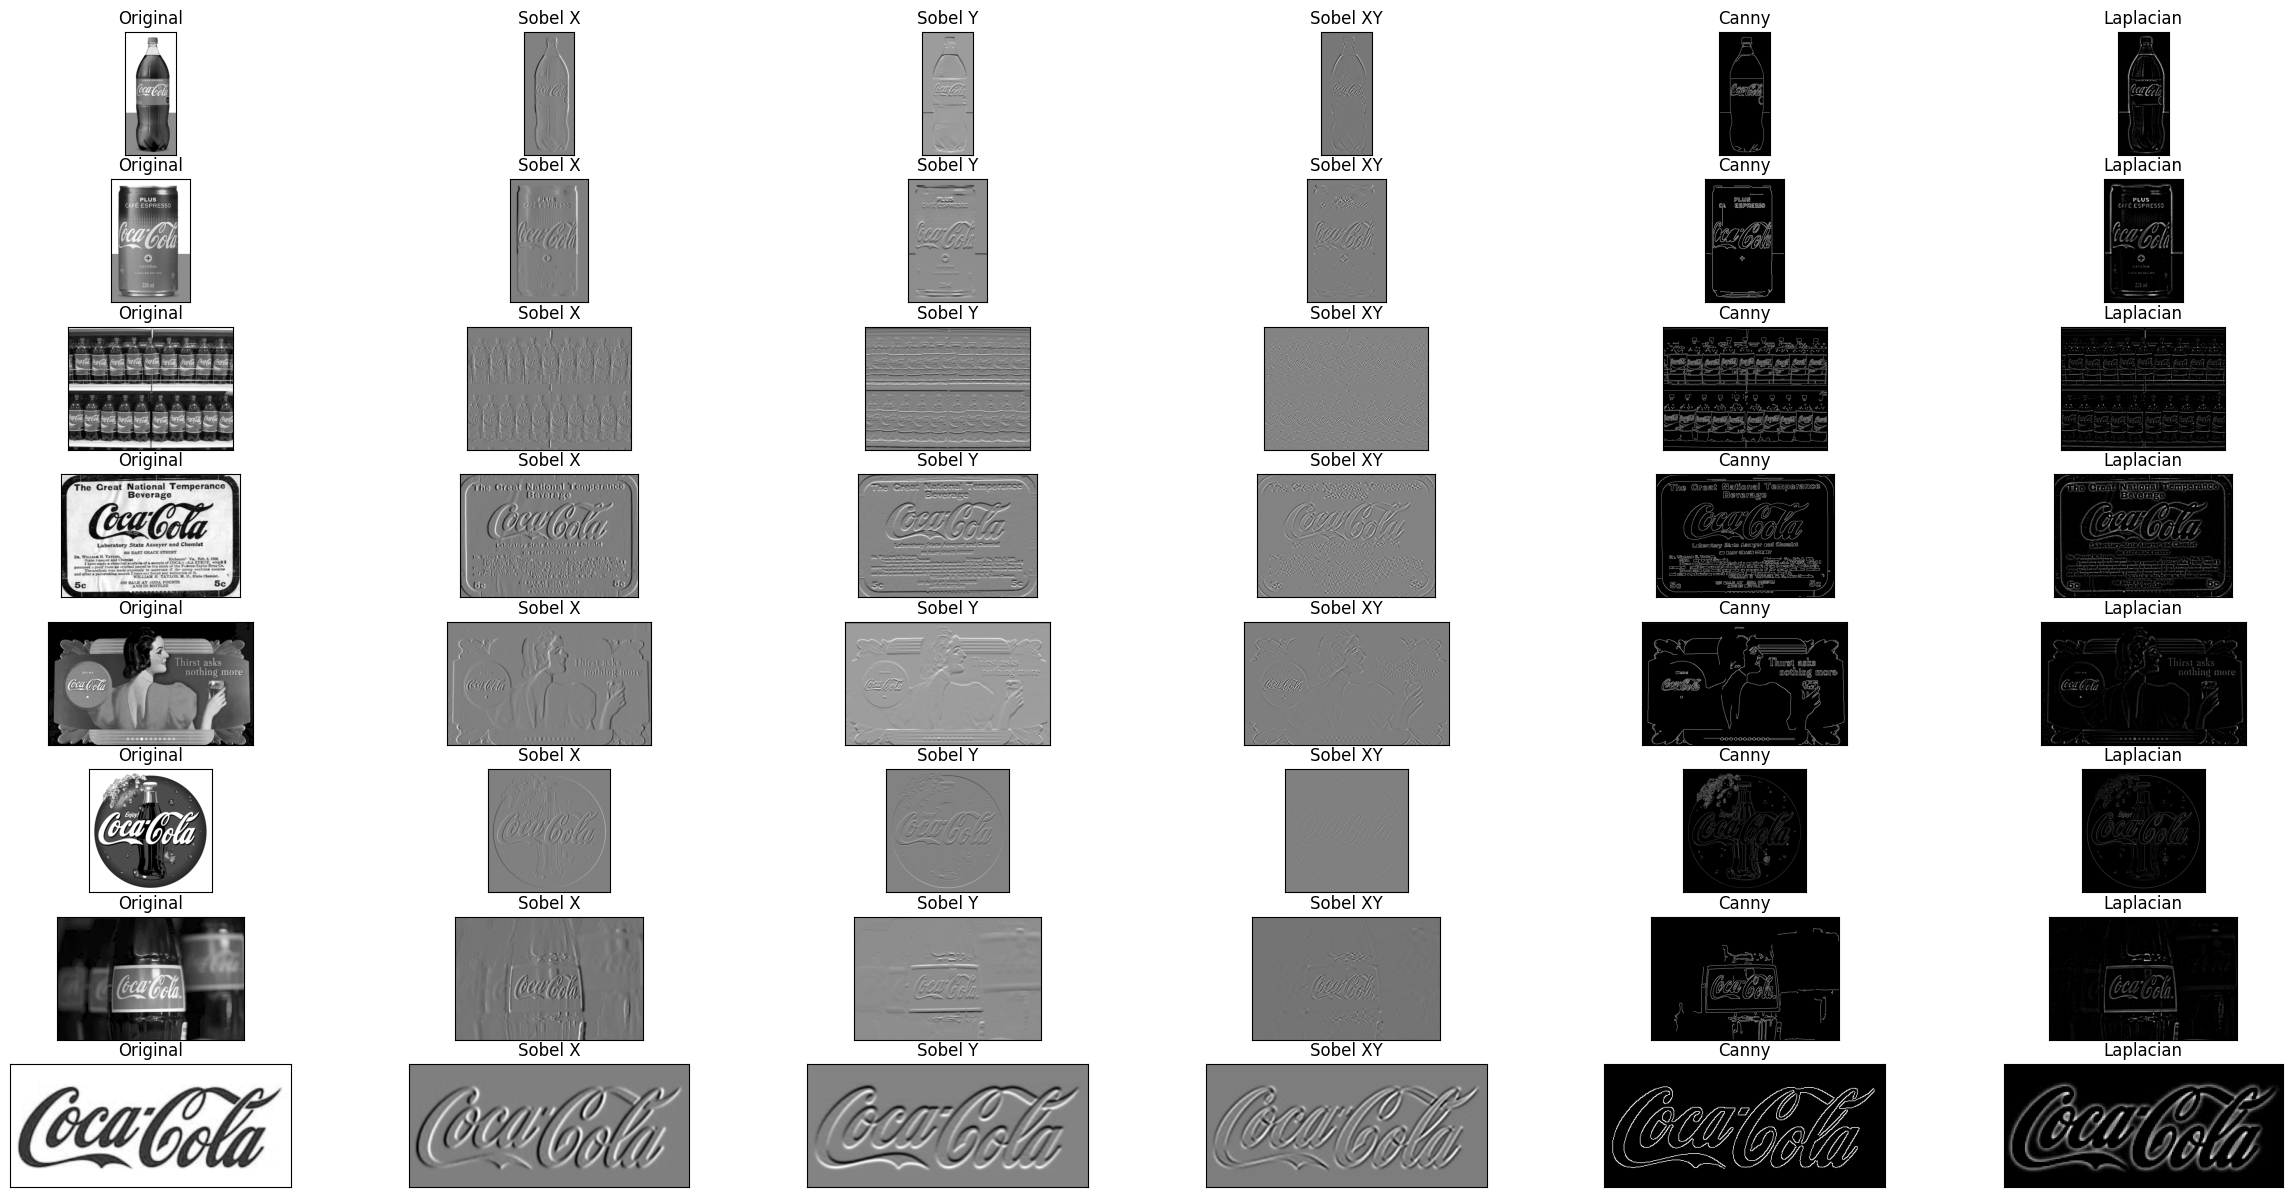

In [196]:
images = [img1_gris, img2_gris, img3_gris, img4_gris, img5_gris, img6_gris, img7_gris, template_gris]

plt.figure(figsize=(30,15))
i = 0
for image in images:
    i += 1

    sigma = 1
    kernel_size = (int(2 * np.ceil(3 * sigma) + 1), int(2 * np.ceil(3 * sigma) + 1))
    
    sobelx = edge_detection(image, True, kernel_size, sigma, 'SobelX', None, None, 5, None)
    sobely = edge_detection(image, True, kernel_size, sigma, 'SobelY', None, None, 5, None)
    sobelxy = edge_detection(image, True, kernel_size, sigma, 'SobelXY', None, None, 5, None)
    canny = edge_detection(image, True, kernel_size, sigma, 'Canny', int(max(0 ,0.5*np.median(image) )), int(min(255,1.8*np.median(image) )), None, None)
    laplacian = edge_detection(image, True, kernel_size, sigma, 'Pyramid', None, None, None, 5)
    laplacian = laplacian[-1]
    
    plt.subplot(len(images), 6, i)
    plt.imshow(image,cmap = 'gray')
    plt.title(f'Original'),plt.xticks([]),plt.yticks([])
    i+=1
    plt.subplot(len(images), 6, i)
    plt.imshow(sobelx,cmap = 'gray')
    plt.title(f'Sobel X'),plt.xticks([]),plt.yticks([])
    i+=1
    plt.subplot(len(images), 6, i)
    plt.imshow(sobely,cmap = 'gray')
    plt.title(f'Sobel Y'),plt.xticks([]),plt.yticks([])
    i+=1
    plt.subplot(len(images), 6, i)
    plt.imshow(sobelxy,cmap = 'gray')
    plt.title(f'Sobel XY'),plt.xticks([]),plt.yticks([])
    i+=1
    plt.subplot(len(images), 6, i)
    plt.imshow(canny,cmap = 'gray')
    plt.title(f'Canny'),plt.xticks([]),plt.yticks([])
    i+=1
    plt.subplot(len(images), 6, i)
    plt.imshow(laplacian,cmap = 'gray')
    plt.title(f'Laplacian'),plt.xticks([]),plt.yticks([])

plt.show()

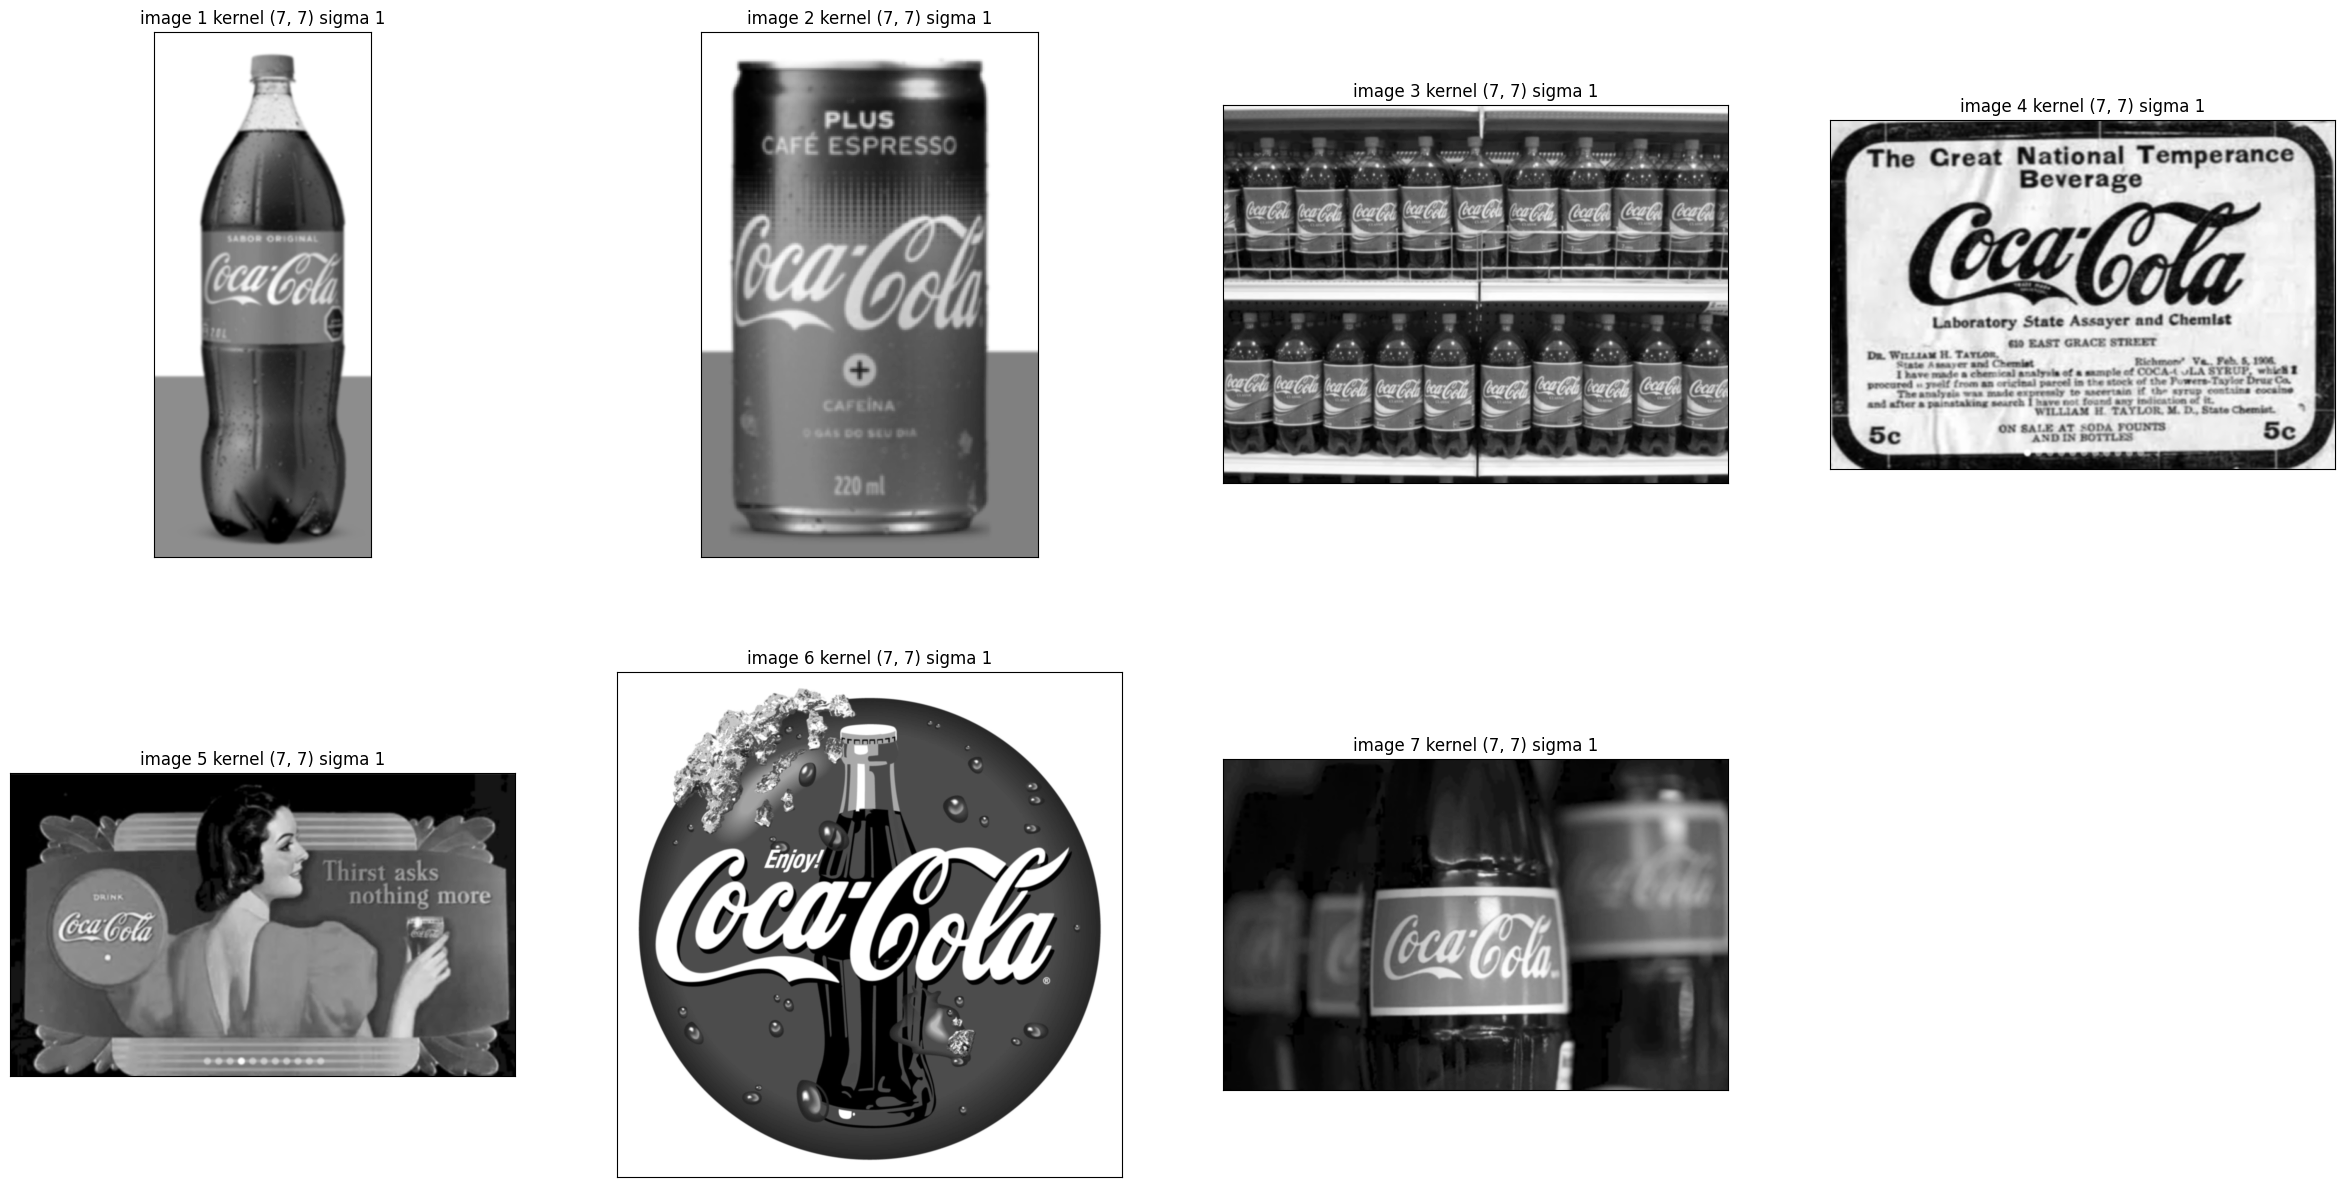

In [197]:
images = [img1_gris, img2_gris, img3_gris, img4_gris, img5_gris, img6_gris, img7_gris]

plt.figure(figsize=(30,15))
i = 0
for image in images:
    i += 1

    sigma = 1
    kernel_size = (int(2 * np.ceil(3 * sigma) + 1), int(2 * np.ceil(3 * sigma) + 1))
    
    blurred_image = cv.GaussianBlur(image, kernel_size, sigma)
    
    plt.subplot(100 * int(np.round(len(images)/4,0)) + 10 * 4 + i)
    plt.imshow(blurred_image,cmap = 'gray')
    plt.title(f'image {i} kernel {kernel_size} sigma {sigma}')
    plt.xticks([])
    plt.yticks([])

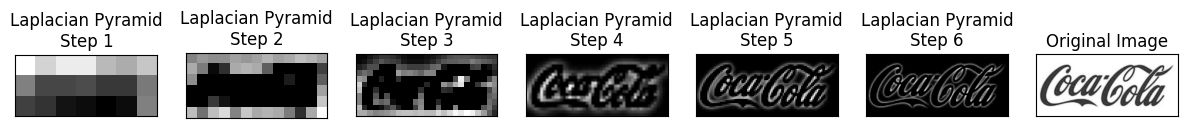

In [198]:
scales = 6
edges_pyr = edge_detection(template_gris, True, (3,3), 3, 'Pyramid', 100, 150, None, scales)

plt.figure(figsize=(15,10))
for i in range(scales):
    plt.subplot(1, scales+1, i+1)
    plt.imshow(edges_pyr[i], cmap='gray')
    plt.title(f'Laplacian Pyramid\nStep {i+1}'), plt.xticks([]), plt.yticks([])

plt.subplot(1, scales+1, scales+1)
plt.imshow(template_gris,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [199]:
def scale_image(image, scale):
    resized_image = cv.resize(image, None, fx = scale, fy = scale)
    return resized_image

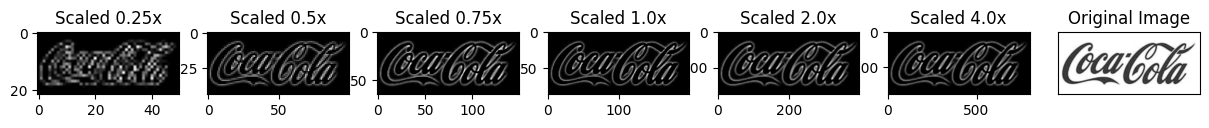

In [200]:
scales = [0.25, 0.5, 0.75, 1., 2., 4.]

plt.figure(figsize=(15,10))
for i in range(len(scales)):
    plt.subplot(1, len(scales)+1, i+1)
    plt.imshow(scale_image(edges_pyr[-1], scales[i]), cmap='gray')
    plt.title(f'Scaled {scales[i]}x')

plt.subplot(1, len(scales)+1, len(scales)+1)
plt.imshow(template_gris,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()

Escalar hacia abajo hace que se pierda calidad y por lo tanto informacion. 
Como el template y las imagenes tienen tamaños y proporciones distintas, hay que tomar una decision para no perder la informacion escalando hacia abajo.
Lo que se hará es escalar las imagenes de modo que el template siempre entre en las mismas.
Como las proporciones son distintas para todas las imagenes, esto significa que el template debe entrar tanto vertical como horizontalmente dentro de la imagen.

A la hora de hacer template matching, si queremos encontrar mas de una posicion, debemos guardar todas las posiciones donde haya una un match alto.
Sin embargo, si en determinada zona tenemos un match alto y nos movemos un pixel hacia la derecha, es probable que el match siga siendo alto.
Para esto utilizaremos un algoritmo llamado NMS (Non-Maximum Suppression) que permite elegir el bounding box mas adecuado.
Este algoritmo utiliza otro llamado IoU (Intersection over Union) que mide el area de interseccion de dos bounding boxes y el area de union de dos bounding boxes.
Mientras mayor sea el numero, mas similares son los bounding boxes y se pueden unir en uno solo.

In [201]:
def calculate_iou(box1, box2):
    # Coordenadas
    x1_tl, y1_tl = box1[0]
    x2_tl, y2_tl = box2[0]
    x1_br, y1_br = box1[1]
    x2_br, y2_br = box2[1]

    # Area de interseccion
    x_overlap = max(0, min(x1_br, x2_br) - max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br) - max(y1_tl, y2_tl))
    intersection_area = x_overlap * y_overlap

    # Area de union
    box1_area = (x1_br - x1_tl) * (y1_br - y1_tl)
    box2_area = (x2_br - x2_tl) * (y2_br - y2_tl)
    union_area = box1_area + box2_area - intersection_area

    # Calcular IoU
    iou = intersection_area / union_area
    return iou

def non_max_suppression(bounding_boxes, confidence_scores, iou_threshold):
    selected_boxes = []
    selected_scores = []

    while bounding_boxes:
        # Buscar el indice del bounding box con mayor puntaje de confianza
        max_index = np.argmax(confidence_scores)
        # Sacar el bounding box de la lista
        box = bounding_boxes.pop(max_index)
        score = confidence_scores.pop(max_index)

        # Agregarlo a los outputs
        selected_boxes.append(box)
        selected_scores.append(score)

        # Ciclar el resto de los bounding box con IoU para eliminar los que se pueda
        indices_to_remove = []
        for i in range(len(bounding_boxes)):
            iou = calculate_iou(box, bounding_boxes[i])
            if iou > iou_threshold:
                indices_to_remove.append(i)

        indices_to_remove.reverse()
        for idx in indices_to_remove:
            bounding_boxes.pop(idx)
            confidence_scores.pop(idx)

    return selected_boxes, selected_scores


In [208]:
def object_detection(img, template, method, detect_thres, iou_thres, scale_factor, max_scale, modding_template, debugging):
    w, h = template.shape[::-1]
    

    if debugging:
        cv.imshow('image', img)
        cv.imshow('template', template)
        cv.waitKey(0)
        cv.destroyAllWindows()

    res = cv.matchTemplate(img.astype(np.uint8), template.astype(np.uint8), eval(method))
    
    # Darle mayor importancia a las imagenes mas grandes
    #res *= 0.1 * np.exp(4.6 / max_scale * scale_factor)
    
    # Buscamos todos los puntos en los que se supera el threshold
    loc = np.where(res >= detect_thres)
    bounding_boxes = []
    confidence_scores = []
    
    for pt in zip(*loc[::-1]):
        # Coordenadas del bounding box
        top_left = pt
        bottom_right = (pt[0] + w, pt[1] + h)

        if modding_template:
            # CHANGE if statement TO modding_template WHEN NOT DEBUGGING
            # CHANGE if statement TO False WHEN DEBUGGING
            top_left_x, top_left_y = top_left
            top_left_x -= int(np.floor(80 / scale_factor))
            top_left = (top_left_x, top_left_y)
            bottom_right_x, bottom_right_y = bottom_right
            bottom_right_x += int(np.floor(110 / scale_factor))
            bottom_right = (bottom_right_x, bottom_right_y)

        bbox = (top_left, bottom_right)

        # Puntaje de confianza
        confidence_score = res[pt[1], pt[0]]

        bounding_boxes.append(bbox)
        confidence_scores.append(confidence_score)
        
    # Utilizar non-maximum suppression para eliminar bounding boxes encimados
    selected_boxes, selected_scores = non_max_suppression(bounding_boxes, confidence_scores, iou_thres)

    return selected_boxes, selected_scores


In [203]:
def logo_detection(image, template, method = 'cv.TM_CCOEFF_NORMED', scales = 10, min_scale = 0.25, max_scale = 5, blur = True, k_size_blur = (3,3), sigma = 1, edge_detection_type = 'Canny', thres1 = 0, thres2 = 255, k_size_sobel = 5, pyr_steps = 5, detect_thres = 0.75, iou_thres = 0.5, modding_template = False, debugging = False):
    # Variables temporales
    temp_image = image.copy()
    temp_template = template.copy()
    global_bounding_boxes = []
    global_confidence_scores = []
    print(edge_detection_type)

    # Aplicar filtro gaussiano y deteccion de bordes a la imagen y template
    filtered_temp_image = edge_detection(temp_image, blur, k_size_blur, sigma, edge_detection_type, thres1, thres2, k_size_sobel, pyr_steps)
    # Al template no le cambiamos el tipo de blur ya que los valores que tiene son suficientemente buenos
    filtered_temp_template = edge_detection(temp_template, blur, (3,3), 3, edge_detection_type, thres1, thres2, k_size_sobel, pyr_steps)
    
    # En caso de elegir piramides LoG, elegimos la de mayor calidad
    if edge_detection_type == 'Pyramid':
        filtered_temp_image = filtered_temp_image[-1]
        filtered_temp_template = filtered_temp_template[-1]
    
    # Escalar imagenes y detectar objetos
    #scale_factors = np.logspace(min_scale, max_scale, num=scales)
    scale_factors = np.logspace(min_scale, max_scale, num=scales, base=np.e)
    progress = 0
    for scale_factor in scale_factors:
        clear_output(wait=True)
        print(f'{progress / len(scale_factors) * 100:.2f}%')
        progress+=1
        scaled_filtered_temp_image = cv.resize(filtered_temp_image, None, fx = scale_factor, fy = scale_factor)

        if (scaled_filtered_temp_image.shape[0] < filtered_temp_template.shape[0] or scaled_filtered_temp_image.shape[1] < filtered_temp_template.shape[1]):
            continue

        scaled_bounding_boxes, confidence_scores = object_detection(scaled_filtered_temp_image, filtered_temp_template, method, detect_thres, iou_thres, scale_factor, max_scale, modding_template, debugging)
        
        bounding_boxes = [[(int(x // scale_factor), int(y // scale_factor)) for x, y in pair] for pair in scaled_bounding_boxes]
        global_bounding_boxes.append(bounding_boxes)
        global_confidence_scores.append(confidence_scores)
    return global_bounding_boxes, global_confidence_scores


In [204]:
def test_image(image, template, method, scales, min_scale, max_scale, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template, debugging):
    # Muchas de las imagenes estan en objetos cilindricos, por lo que el inicio y final de 
    # la palabra Coca Cola está distorsionado por perspectiva.
    # modding_template quita del template un cuarto de la derecha y un cuarto de la izquierda 
    t_template = template.copy()
    if modding_template:
        #modded_width = t_template.shape[1] // 4
        mod_template = t_template[:, 80 : -110]
        t_template = mod_template.copy()

    # El IoU threshold de este punto elimina bounding boxes en una misma escala
    bounding_boxes, confidence_scores = logo_detection(image, t_template, method, scales, min_scale, max_scale, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, modding_template, debugging)
    # Los bounding boxes y confidence scores almacenados aqui estan agrupados por escala

    list_bounding_boxes = []
    list_confidence_scores = []

    for sublist_scores, sublist_boxes in zip(confidence_scores, bounding_boxes):
        for score, box in zip(sublist_scores, sublist_boxes):
            if sublist_scores:
                list_bounding_boxes.append(box)
                list_confidence_scores.append(score)
    # A partir de este punto, todos los bounding boxes de todas las escalas estan juntos

    # El IoU threshold de este punto elimina bounding boxes entre distintas escalas
    print(list_confidence_scores)
    mod_flat_bounding_boxes, mod_flat_confidence_scores = non_max_suppression(list_bounding_boxes, list_confidence_scores, iou_thres2)
    print(mod_flat_confidence_scores)
    return mod_flat_bounding_boxes, mod_flat_confidence_scores


In [205]:
def draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template, colors, debugging):

    img_salida = image.copy()
    for i, (bbox, confidence) in enumerate(zip(bounding_boxes, confidence_scores)):
        top_left, bottom_right = bbox
        color = colors[i % len(colors)]
        cv.rectangle(img_salida, top_left, bottom_right, color, 2)
        
        # Display the confidence score alongside the bounding box
        cv.putText(img_salida, f'Confidence: {confidence*100:.0f}%', (top_left[0], top_left[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    
    return img_salida


In [206]:
template = cv.imread(img_path2 + '/mod_pattern.png', cv.IMREAD_GRAYSCALE)

# Quitamos los pedazos blancos del template para evitar match en zonas donde no deberia.
#template = template[27:152,7:388]

colors = [(random.randint(0, 100), random.randint(0, 100), random.randint(0, 100)) for _ in range(30)]
image_names = ['/coca_logo_1.png', '/coca_logo_2.png', '/coca_multi.png', '/coca_retro_1.png', '/coca_retro_2.png', '/COCA-COLA-LOGO.jpg', '/logo_1.png']

99.00%
[0.12175424, 0.12749864, 0.18152805, 0.3392734, 0.44150972, 0.22420143, 0.14456391, 0.1262604, 0.1252607]
[0.44150972]


([], [])

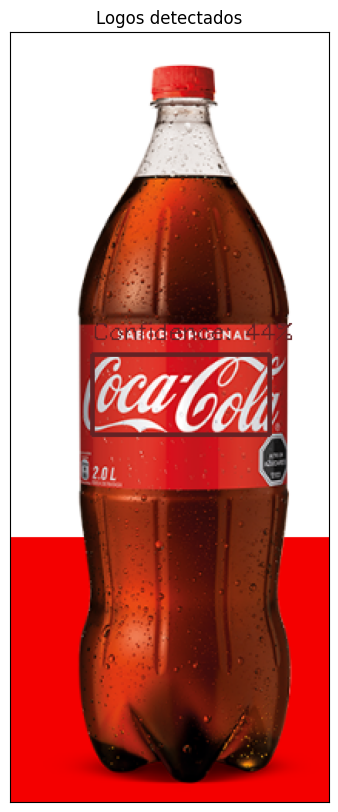

In [273]:
index = 0
image = cv.imread(img_path1 + image_names[index], cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[1]
scales = 100
min_scale = -2.3
max_scale = 1.8
blur = True
blur_kernel = (5,5)
blur_sigma = 1
edge_method = 'Canny'
canny_thres1 = 100
canny_thres2 = 150
sobel_kernel = 5
pyramid_steps = 3
detect_thres = 0.12
iou_thres1 = 0.1
iou_thres2 = 0.1
modding_template = True
debugging = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, min_scale, max_scale, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template, debugging)
image = cv.imread(img_path1 + image_names[index])
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
output = draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template, colors, debugging)

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.title("Logos detectados")
plt.xticks([])
plt.yticks([])

99.00%
[0.1413851, 0.23976022, 0.3866714, 0.2601658, 0.14878032]
[0.3866714]


([], [])

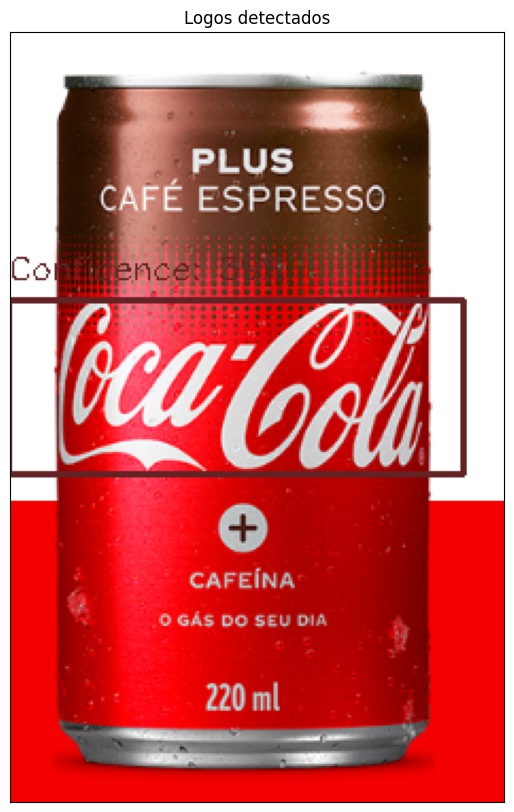

In [272]:
index = 1
image = cv.imread(img_path1 + image_names[index], cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[1]
scales = 100
min_scale = -2.3
max_scale = 1.8
blur = True
blur_kernel = (5,5)
blur_sigma = 1
edge_method = 'Canny'
canny_thres1 = 100
canny_thres2 = 150
sobel_kernel = 5
pyramid_steps = 3
detect_thres = 0.12
iou_thres1 = 0.1
iou_thres2 = 0.1
modding_template = True
debugging = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, min_scale, max_scale, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template, debugging)
image = cv.imread(img_path1 + image_names[index])
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
output = draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template, colors, debugging)

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.title("Logos detectados")
plt.xticks([])
plt.yticks([])

99.00%
[0.12005783, 0.12536813, 0.13161938, 0.12934616, 0.12849426, 0.124645635, 0.121863656, 0.120066814, 0.17645898, 0.16953163, 0.1691864, 0.1666822, 0.16326995, 0.16089347, 0.15224591, 0.15215306, 0.15167117, 0.1503084, 0.14896977, 0.14105527, 0.1371302, 0.12131608, 0.121275514, 0.120466344, 0.2223803, 0.21356651, 0.2075913, 0.20508471, 0.2043318, 0.20319583, 0.2012462, 0.20100035, 0.19978972, 0.1907547, 0.18710904, 0.18535423, 0.16821916, 0.14439346, 0.13588911, 0.1288766, 0.20188965, 0.19946767, 0.19877933, 0.1976689, 0.1954043, 0.18880774, 0.18198185, 0.18108901, 0.18043852, 0.17798437, 0.17787951, 0.17573285, 0.17458697, 0.14837827, 0.14831093, 0.13712037, 0.13603728, 0.12802422, 0.14767651, 0.14426218, 0.14346221, 0.13976105, 0.1397174, 0.13741484, 0.13431986, 0.13171154, 0.12888105, 0.12859763, 0.12255291, 0.12192511, 0.120862536, 0.120094314, 0.13551067, 0.13115539, 0.12645422, 0.12614475, 0.12585717, 0.12252642, 0.12823384, 0.122475676, 0.1209075, 0.12076366]
[0.2223803, 0.

([], [])

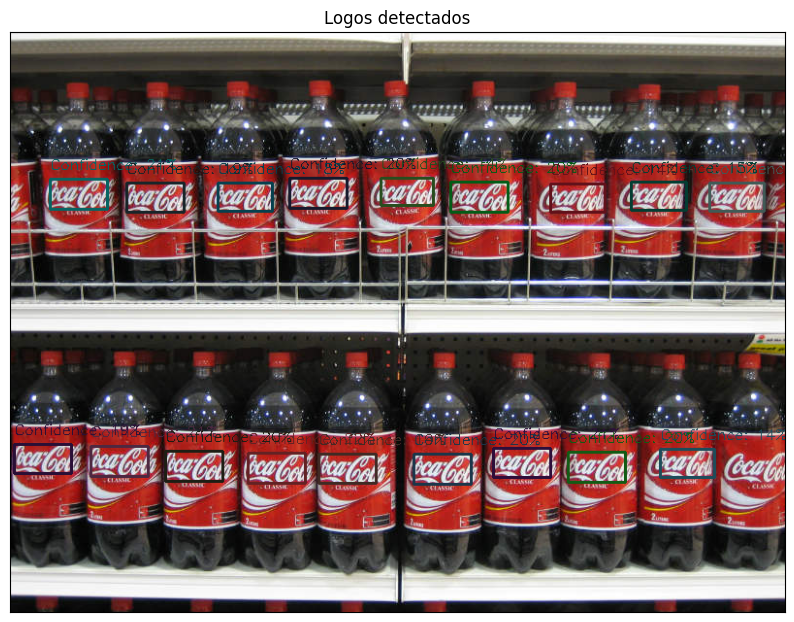

In [271]:
index = 2
image = cv.imread(img_path1 + image_names[index], cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[1]
scales = 100
min_scale = -2.3
max_scale = 1.8
blur = True
blur_kernel = (5,5)
blur_sigma = 1
edge_method = 'Canny'
canny_thres1 = 100
canny_thres2 = 150
sobel_kernel = 5
pyramid_steps = 3
detect_thres = 0.12
iou_thres1 = 0.1
iou_thres2 = 0.1
modding_template = True
debugging = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, min_scale, max_scale, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template, debugging)
image = cv.imread(img_path1 + image_names[index])
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
output = draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template, colors, debugging)

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.title("Logos detectados")
plt.xticks([])
plt.yticks([])

99.00%
[0.12248127, 0.15370092, 0.15211575, 0.12085558, 0.1300145, 0.12603036]
[0.15370092]


([], [])

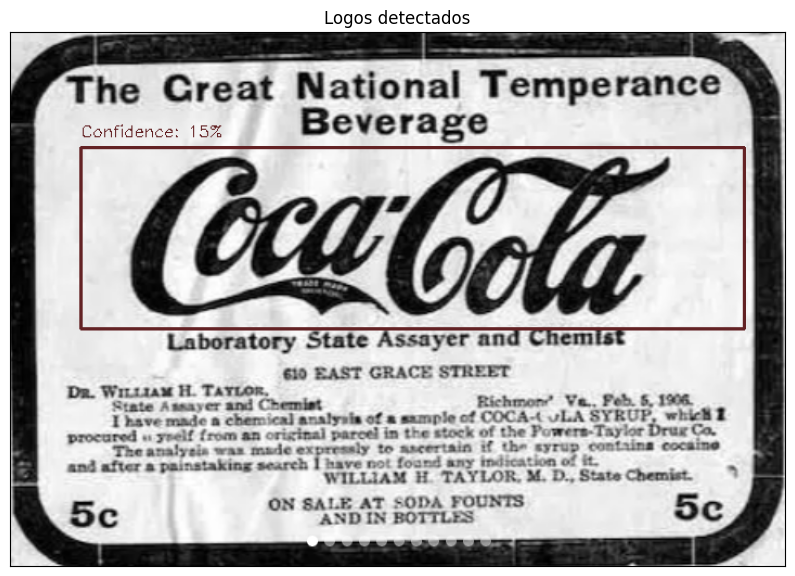

In [270]:
index = 3
image = cv.imread(img_path1 + image_names[index], cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[1]
scales = 100
min_scale = -2.3
max_scale = 1.8
blur = True
blur_kernel = (5,5)
blur_sigma = 1
edge_method = 'Canny'
canny_thres1 = 100
canny_thres2 = 150
sobel_kernel = 5
pyramid_steps = 3
detect_thres = 0.12
iou_thres1 = 0.1
iou_thres2 = 0.1
modding_template = True
debugging = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, min_scale, max_scale, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template, debugging)
image = cv.imread(img_path1 + image_names[index])
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
output = draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template, colors, debugging)

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.title("Logos detectados")
plt.xticks([])
plt.yticks([])

99.00%
[0.14338267, 0.18211903, 0.20078862, 0.1714875, 0.15597607, 0.14875236, 0.15310943, 0.14014274, 0.1283263, 0.124594554]
[0.20078862]


([], [])

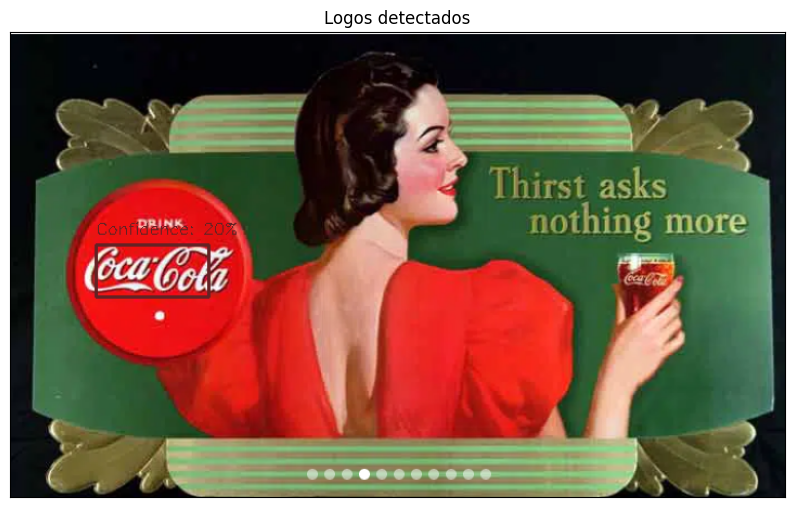

In [269]:
index = 4
image = cv.imread(img_path1 + image_names[index], cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[1]
scales = 100
min_scale = -2.3
max_scale = 1.8
blur = True
blur_kernel = (5,5)
blur_sigma = 1
edge_method = 'Canny'
canny_thres1 = 100
canny_thres2 = 150
sobel_kernel = 5
pyramid_steps = 3
detect_thres = 0.12
iou_thres1 = 0.1
iou_thres2 = 0.1
modding_template = True
debugging = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, min_scale, max_scale, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template, debugging)
image = cv.imread(img_path1 + image_names[index])
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
output = draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template, colors, debugging)

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.title("Logos detectados")
plt.xticks([])
plt.yticks([])

99.00%
[0.10474248, 0.10778799, 0.1052987]
[0.10778799]


([], [])

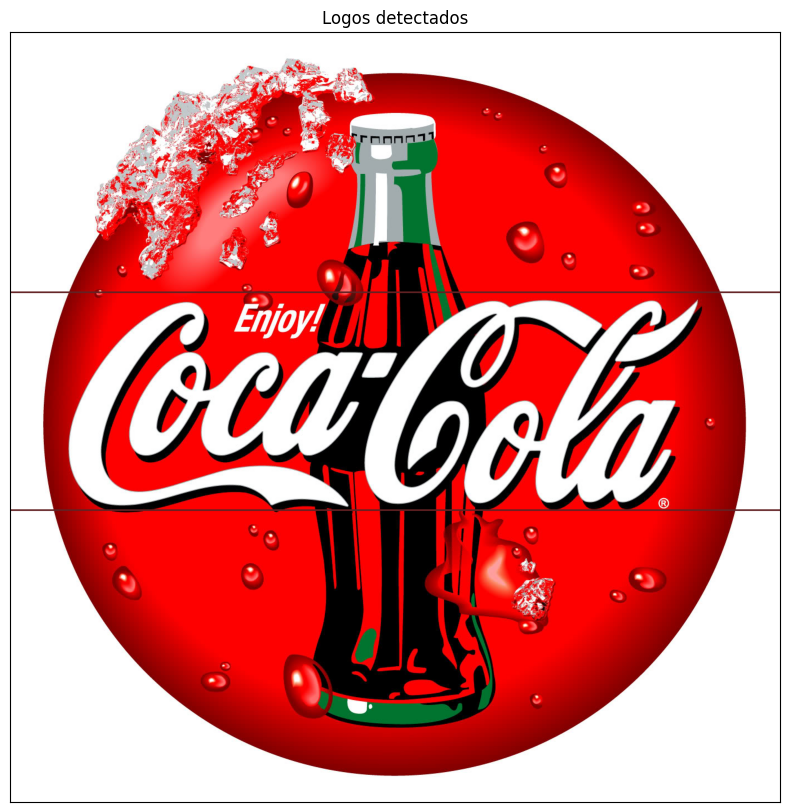

In [265]:
index = 5
image = cv.imread(img_path1 + image_names[index], cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[1]
scales = 100
min_scale = -2.3
max_scale = -0.9
blur = True
blur_kernel = (5,5)
blur_sigma = 3
edge_method = 'Canny'
canny_thres1 = 100
canny_thres2 = 150
sobel_kernel = 5
pyramid_steps = 3
detect_thres = 0.1
iou_thres1 = 0.1
iou_thres2 = 0.1
modding_template = True
debugging = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, min_scale, max_scale, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template, debugging)
image = cv.imread(img_path1 + image_names[index])
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
output = draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template, colors, debugging)

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.title("Logos detectados")
plt.xticks([])
plt.yticks([])

99.00%
[0.16097625, 0.19189899, 0.17002805, 0.12824835]
[0.19189899]


([], [])

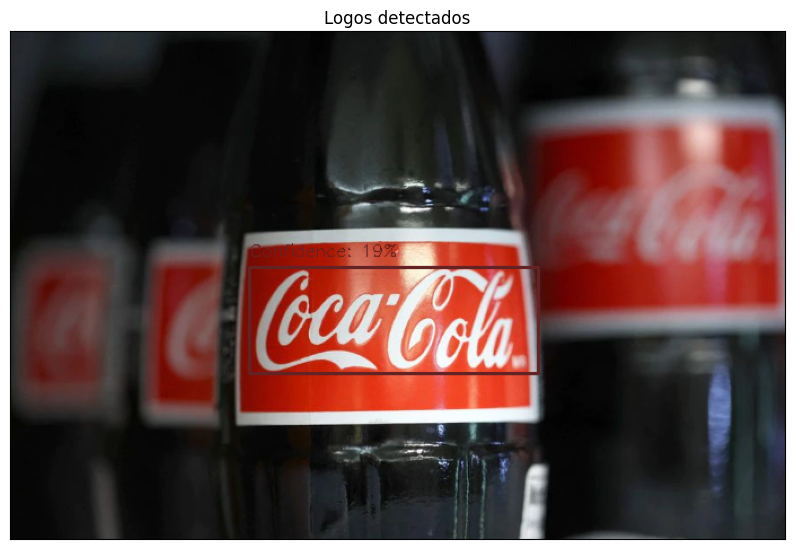

In [274]:
index = 6
image = cv.imread(img_path1 + image_names[index], cv.IMREAD_GRAYSCALE)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[1]
scales = 100
min_scale = -2.3
max_scale = 1.8
blur = True
blur_kernel = (5,5)
blur_sigma = 1
edge_method = 'Canny'
canny_thres1 = 100
canny_thres2 = 150
sobel_kernel = 5
pyramid_steps = 3
detect_thres = 0.12
iou_thres1 = 0.1
iou_thres2 = 0.1
modding_template = True
debugging = False

bounding_boxes, confidence_scores = test_image(image, template, method, scales, min_scale, max_scale, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template, debugging)
image = cv.imread(img_path1 + image_names[index])
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
output = draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template, colors, debugging)

plt.figure(figsize=(10,10))
plt.imshow(output)
plt.title("Logos detectados")
plt.xticks([])
plt.yticks([])

99.00%
[0.16097625, 0.19189899, 0.17002805, 0.12824835]
[0.19189899]
Image (7/7)


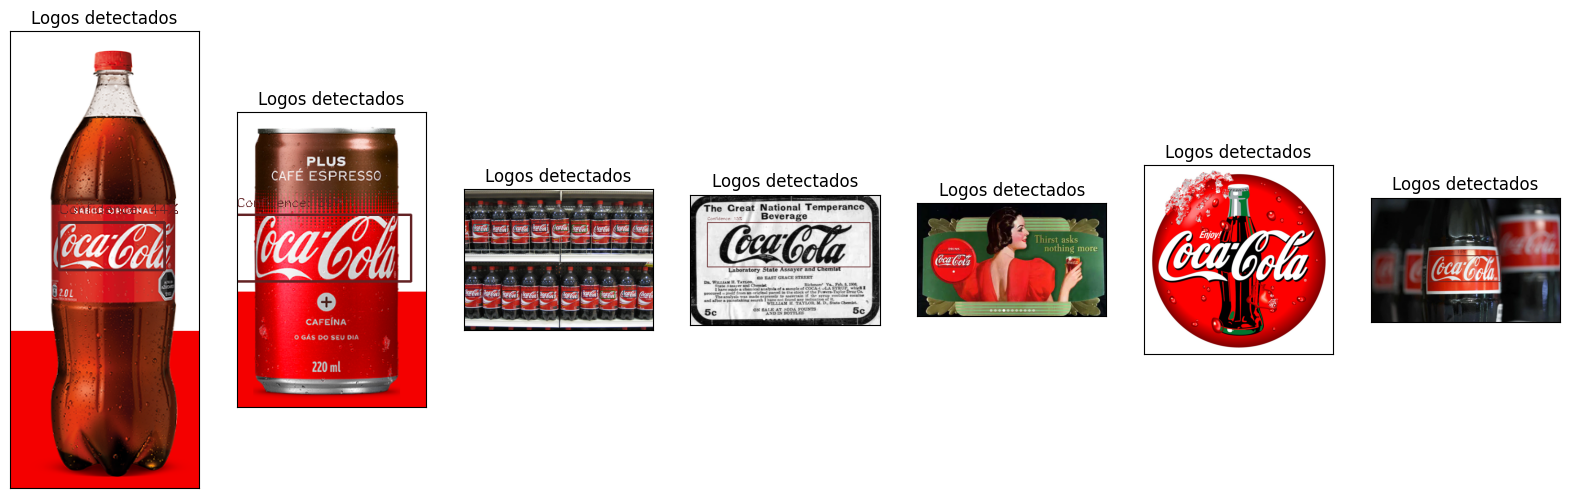

In [275]:
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
method = methods[1]
scales = 100
min_scale = -2.3
max_scale = 1.8
blur = True
blur_kernel = (5,5)
blur_sigma = 1
edge_method = 'Canny'
canny_thres1 = 100
canny_thres2 = 150
sobel_kernel = 5
pyramid_steps = 3
detect_thres = 0.12
iou_thres1 = 0.1
iou_thres2 = 0.1
modding_template = True
debugging = False

plt.figure(figsize=(20,20))
count = 1
progress2 = 0
for image_name in image_names:
    progress2 += 1
    image = cv.imread(img_path1 + image_name, cv.IMREAD_GRAYSCALE)
    bounding_boxes, confidence_scores = test_image(image, template, method, scales, min_scale, max_scale, blur, blur_kernel, blur_sigma, edge_method, canny_thres1, canny_thres2, sobel_kernel, pyramid_steps, detect_thres, iou_thres1, iou_thres2, modding_template, debugging)
    image = cv.imread(img_path1 + image_name)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    output = draw_bounding_boxes(image, template, bounding_boxes, confidence_scores, modding_template, colors, debugging)
    print(f'Image ({progress2}/7)')

    plt.subplot(1,7,count)
    plt.imshow(output)
    plt.title("Logos detectados")
    plt.xticks([])
    plt.yticks([])
    count += 1


Se pudo conseguir un algoritmo que detecte en todas las imagenes multiples instancias del logo. Parametros que ayudaron a realizar esto:
1. Aplicar un filtro gaussiano de kernel (5,5) y sigma 1.
2. Aplicar el metodo de deteccion de bordes de Canny con threshold (100, 150).
3. Escalado de imagenes. El logo aparece en distintas proporciones y tamaños a lo largo de las imagenes. En esta ocasion decidí escalar las imagenes hacia arriba en vez del template hacia abajo para mantener la calidad de imagen.
4. El escalado se hizo exponencialmente. Esto quizas es un poco de forzado pero analizando las imagenes, la mayoria de las imagenes tenian el logo mas pequeño que el tamaño del template entonces el escalado debia ser mas detallado hacia abajo que hacia arriba.
5. La deteccion de bordes se realizó después de escalar las imagenes. Intenté hacerlo antes pero cuando se escalaba la imagen se perdian detalles de los bordes y no daba buenos resultados.
6. Recorte del template. Como se mencionó anteriormente, el template no tiene perspectiva mientras que la imagen 1, 2, 3 y 6 si tienen perspectiva. Se recortó de modo que la deteccion se hizo con "ca Co" en vez de "Coca Cola". Esto dio muy buenos resultados.

A la unica imagen que no pude detectarle el logo es la imagen 'COCA-COLA-LOGO'. Motivos por los cuales creo que fue dificil detectar el logo: 
1. El hielo en la parte superior izquierda de la imagen. Al hacer deteccion de bordes, aqui se encuentran muchisimos bordes.
2. El nombre 'Coca Cola' tiene un sombreado. Lo mismo que el punto uno pero en menor medida.
El hecho de que haya un monton de bordes en la parte del hielo hacia que hubiese mucha coincidencia entre el template y una imagen llena de blanco (que en esencia es lo que es una imagen llena de bordes).
La unica solucion para esto es aumentar el filtro gaussiano hasta el punto en que ese hielo se difumina tanto que ya no se ven bordes. De esta manera si pude conseguir detectar el logo (ver celda mas arriba). El problema es que aplicar un filtro tan fuerte en las otras imagenes hace que se pierda todo (me imagino que es porque la imagen 'COCA-COLA-LOGO' es la mas grande de todas) y no se ve ningun borde en toda la imagen.

En cuanto a la deteccion multiple, solo encontré tres instancias:
1. En la imagen 'coca_multi' no hubo problema, pude encontrar todos los logos excepto uno (la botella de abajo y mas a la derecha). Si bajo el threshold para detectar mas coincidencias, puedo detectarlo pero en las otras imagenes empiezo a detectar logos de manera incorrecta.
2. En la imagen 'coca_retro_2' está el logo en la tapa que se encontró sin problemas, pero también está el logo del vaso de coca cola. Ese no se pudo detectar principalmente por la calidad de la imagen. Si ajusto los parametros especificamente para esa imagen lo puedo detectar pero esos parametros no me funcionan para las otras imagenes.
3. En la imagen 'logo_1' se alcanza a distinguir la 'Cola' de 'Coca Cola' en la botella de la derecha a la principal. Esta no la pude detectar porque está demasiado difuminada. Yo, como humano, la puedo identificar por los colores y forma pero si nunca hubiera visto el logo coca cola considero que no se podria leer.

En conclusion, hacer template matching no es la mejor herramienta para este tipo de tareas, en las cuales las imagenes no tienen el logo tal y como está en el template. Requiere ver las imagenes sobre las cuales se va a trabajar e ir con ensayo y error viendo cuales parametros funcionan, lo cual siento que va un poco en contra de la idea de la tarea.